In [1]:
%matplotlib inline

from itertools import chain
import re

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from gensim.models import Word2Vec

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Token

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [4]:
full_mail_df = pd.read_csv('data/cleaned_enron_mail.csv', index_col=0)
full_mail_df.head()

from  \
date                                               
1980-01-01 00:00:00   jeffrey.shankman@enron.com   
1980-01-01 00:00:00      jeff.dasovich@enron.com   
1980-01-01 00:00:00        harry.arora@enron.com   
1980-01-01 00:00:00  debra.perlingiere@enron.com   
1980-01-01 00:00:00  debra.perlingiere@enron.com   

                                                  to  \
date                                                   
1980-01-01 00:00:00            david.oxley@enron.com   
1980-01-01 00:00:00         ginger.dernehl@enron.com   
1980-01-01 00:00:00          pushkar.shahi@enron.com   
1980-01-01 00:00:00           hissongm@dteenergy.com   
1980-01-01 00:00:00  bernadette.dowling@conectiv.com   

                                                             subject  \
date                                                                   
1980-01-01 00:00:00                                              NaN   
1980-01-01 00:00:00                    Re: Washington, DC Dept. Mtg.   
1980-01-01 00:00:00                                  US fixed income   
1980-01-01 00:00:00  Re: DTE Energy Trading--Spec Prov to GISB; GISB   
1980-01-01 00:00:00    Re: Contract for Conectiv Energy Supply, Inc.   

                                                               message  \
date                                                                     
1980-01-01 00:00:00  Weather:  Mark Tawney--Director\n\n Steven Vu ...   
1980-01-01 00:00:00  Hi.  I'm sorry for not responding.  I'm actual...   
1980-01-01 00:00:00  Pushkar\n\nI quickly plotted the short and the...   
1980-01-01 00:00:00  Marcia,\n\nThank you for your e-mail.  Concern...   
1980-01-01 00:00:00  Bernadette:\n\nIn response to your reguest for...   

                                                   file  
date                                                     
1980-01-01 00:00:00  shankman-j/discussion_threads/298.  
1980-01-01 00:00:00       dasovich-j/all_documents/689.  
1980-01-01 00:00:00      arora-h/discussion_threads/19.  
1980-01-01 00:00:00   perlingiere-d/all_documents/2247.  
1980-01-01 00:00:00      perlingiere-d/all_documents/3.

In [5]:
mail_df = pd.read_csv('data/enron-mails-insiders-only.csv', index_col=0)
mail_df.head()

date                      from                        to  \
0  1980-01-01 00:00:00   jeff.dasovich@enron.com     susan.scott@enron.com   
1  1980-01-01 00:00:00     susan.scott@enron.com     drew.fossum@enron.com   
2  1980-01-01 00:00:00        kim.ward@enron.com  jason.williams@enron.com   
3  1980-01-01 00:00:00  jason.williams@enron.com        kim.ward@enron.com   
4  1980-01-01 00:00:00  jason.williams@enron.com      tana.jones@enron.com   

                         subject  \
0           Re: Pedersen inquiry   
1     Gallup compressor contract   
2               Re: Border Steel   
3                           GTCs   
4  Re: Fletcher Challenge/Apache   

                                             message  \
0  Hey, you be talkin' to gas trash, counsel.\n\n...   
1  I've reviewed the O&M Agreement and here is a ...   
2  J.-\n\nJust got an RFP from Border Steel, Inc....   
3  Kim -\n\nAnnex A are the printed GTC\n\nAnnex ...   
4  Tana -\n\nWith respect to assignment of the Fl...   

                                 file  
0       dasovich-j/all_documents/596.  
1      scott-s/discussion_threads/30.  
2      ward-k/discussion_threads/157.  
3  williams-j/discussion_threads/109.  
4        williams-j/all_documents/85.

### Documents cleaning

In [6]:
nlp = spacy.load('en')
token_regexp = re.compile(r'^[a-zA-Z]+$')

stop_words_getter = lambda token: token.is_stop or token.lower_ in STOP_WORDS or token.lemma_ in STOP_WORDS
Token.set_extension('is_stop', getter=stop_words_getter, force=True)

def is_legal_token(token):
    if token.is_punct or token._.is_stop or len(token) == 1:
        return False
    return token_regexp.fullmatch(token.lemma_) is not None

def clean_spacy_sentence(sentence):
    cleaned_sent = []    
    for token in sentence:        
        if is_legal_token(token):
            cleaned_sent.append(token.lemma_.lower())
            
    return cleaned_sent

def clean_text(text):
    doc = nlp(text)
    
    cleaned_txt = []
    
    for sent in doc.sents:
        cleaned = clean_spacy_sentence(sent)
        if len(cleaned) > 1:
            cleaned_txt.append(cleaned)
    
    return cleaned_txt

In [6]:
msg = mail_df.loc[2].message

print(msg)

clean_text(msg)

J.-

Just got an RFP from Border Steel, Inc., A Texas Corporation.  The RFP 
response is due on Thursday - and I know you said steel companies are BAD 
but,


[['rfp', 'border', 'steel', 'texas', 'corporation'],
 ['rfp', 'response', 'thursday', 'know', 'steel', 'company', 'bad']]

In [7]:
mail_df['lemmas'] = mail_df.message.progress_map(clean_text)
mail_df.head()

date                      from                        to  \
0  1980-01-01 00:00:00   jeff.dasovich@enron.com     susan.scott@enron.com   
1  1980-01-01 00:00:00     susan.scott@enron.com     drew.fossum@enron.com   
2  1980-01-01 00:00:00        kim.ward@enron.com  jason.williams@enron.com   
3  1980-01-01 00:00:00  jason.williams@enron.com        kim.ward@enron.com   
4  1980-01-01 00:00:00  jason.williams@enron.com      tana.jones@enron.com   

                         subject  \
0           Re: Pedersen inquiry   
1     Gallup compressor contract   
2               Re: Border Steel   
3                           GTCs   
4  Re: Fletcher Challenge/Apache   

                                             message  \
0  Hey, you be talkin' to gas trash, counsel.\n\n...   
1  I've reviewed the O&M Agreement and here is a ...   
2  J.-\n\nJust got an RFP from Border Steel, Inc....   
3  Kim -\n\nAnnex A are the printed GTC\n\nAnnex ...   
4  Tana -\n\nWith respect to assignment of the Fl...   

                                 file  \
0       dasovich-j/all_documents/596.   
1      scott-s/discussion_threads/30.   
2      ward-k/discussion_threads/157.   
3  williams-j/discussion_threads/109.   
4        williams-j/all_documents/85.   

                                              lemmas  
0  [[hey, talkin, gas, trash, counsel], [jeff, da...  
1  [[review, agreement, summary, provision, use, ...  
2  [[rfp, border, steel, texas, corporation], [rf...  
3  [[kim, annex, print, gtc, annex, credit, provi...  
4  [[tana, respect, assignment, fletcher, challen...

In [41]:
min_mail_len = 10

full_df_mail_lens = full_mail_df.message.map(len)
full_mail_df = full_mail_df[(full_df_mail_lens > min_mail_len) & 
                            (full_df_mail_lens < nlp.max_length)]

In [42]:
full_mail_df['lemmas'] = full_mail_df.message.progress_map(clean_text)
full_mail_df.head()

from  \
date                                               
1980-01-01 00:00:00   jeffrey.shankman@enron.com   
1980-01-01 00:00:00      jeff.dasovich@enron.com   
1980-01-01 00:00:00        harry.arora@enron.com   
1980-01-01 00:00:00  debra.perlingiere@enron.com   
1980-01-01 00:00:00  debra.perlingiere@enron.com   

                                                  to  \
date                                                   
1980-01-01 00:00:00            david.oxley@enron.com   
1980-01-01 00:00:00         ginger.dernehl@enron.com   
1980-01-01 00:00:00          pushkar.shahi@enron.com   
1980-01-01 00:00:00           hissongm@dteenergy.com   
1980-01-01 00:00:00  bernadette.dowling@conectiv.com   

                                                             subject  \
date                                                                   
1980-01-01 00:00:00                                              NaN   
1980-01-01 00:00:00                    Re: Washington, DC Dept. Mtg.   
1980-01-01 00:00:00                                  US fixed income   
1980-01-01 00:00:00  Re: DTE Energy Trading--Spec Prov to GISB; GISB   
1980-01-01 00:00:00    Re: Contract for Conectiv Energy Supply, Inc.   

                                                               message  \
date                                                                     
1980-01-01 00:00:00  Weather:  Mark Tawney--Director\n\n Steven Vu ...   
1980-01-01 00:00:00  Hi.  I'm sorry for not responding.  I'm actual...   
1980-01-01 00:00:00  Pushkar\n\nI quickly plotted the short and the...   
1980-01-01 00:00:00  Marcia,\n\nThank you for your e-mail.  Concern...   
1980-01-01 00:00:00  Bernadette:\n\nIn response to your reguest for...   

                                                   file  \
date                                                      
1980-01-01 00:00:00  shankman-j/discussion_threads/298.   
1980-01-01 00:00:00       dasovich-j/all_documents/689.   
1980-01-01 00:00:00      arora-h/discussion_threads/19.   
1980-01-01 00:00:00   perlingiere-d/all_documents/2247.   
1980-01-01 00:00:00      perlingiere-d/all_documents/3.   

                                                                lemmas  
date                                                                    
1980-01-01 00:00:00  [[weather, mark, tawney], [director, steven, v...  
1980-01-01 00:00:00  [[sorry, respond], [actually, morning, noon], ...  
1980-01-01 00:00:00  [[pushkar, quickly, plot, short, long, curve, ...  
1980-01-01 00:00:00  [[marcia, thank, mail], [concern, confirm, enr...  
1980-01-01 00:00:00  [[bernadette, response, reguest, master, firm,...

### Documents embedding

In [43]:
emb_dim = 300

model = Word2Vec(sentences=chain(*full_mail_df.lemmas.values), size=emb_dim, min_count=1, iter=20, workers=4)

In [54]:
def map_lemmas_to_mail_vector(lemmas):
    if len(lemmas) > 0:
        return np.mean([model.wv[word] for word in chain(*lemmas)], axis=0)
    return np.ones(emb_dim)

map_lemmas_to_mail_vector(mail_df.lemmas[0]).shape

(300,)

In [55]:
mail_df['vec'] = mail_df.lemmas.map(map_lemmas_to_mail_vector)
mail_df.vec[:4]

0    [-0.00010902803, -0.00020871747, -8.936661e-05...
1    [0.00012921973, 1.72449e-05, 3.0024694e-05, 5....
2    [0.000521041, -0.00040646174, -0.00025745892, ...
3    [0.0004228399, 0.00051947875, 0.00044767355, -...
Name: vec, dtype: object

### Explore similar messages

In [56]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def get_similarity_scores(base_point, target_points, dist_type='cosine'):
    if dist_type == 'cosine':
        return cosine_similarity([base_point], target_points)[0]
    elif dist_type == 'euclidean':
        scores = euclidean_distances([base_point], target_points)[0]
        return 1 - scores / scores.sum()
    else:
        raise NotImplementedError(f"{dist_type} metric is not implemented")


In [57]:
all_msg_vecs = np.vstack(mail_df.vec.values)
all_msg_vecs

array([[-1.09028028e-04, -2.08717465e-04, -8.93666074e-05, ...,
         6.78381330e-05, -4.63543038e-05, -6.26798064e-05],
       [ 1.29219727e-04,  1.72448999e-05,  3.00246938e-05, ...,
         4.35235161e-05,  7.44314093e-05,  1.34142681e-06],
       [ 5.21040987e-04, -4.06461739e-04, -2.57458916e-04, ...,
        -4.89409431e-04,  3.44616914e-04,  1.07068532e-04],
       ...,
       [-1.48927997e-04,  3.22454907e-05,  2.05196571e-04, ...,
        -9.62531776e-05, -1.41506125e-05, -2.84377438e-05],
       [ 1.22546568e-04, -2.11337920e-05, -2.49195698e-04, ...,
        -2.06251192e-04, -1.67315622e-04, -3.13898694e-04],
       [-1.88297527e-05,  3.34286815e-05, -1.74101107e-04, ...,
        -2.40316193e-04, -2.80101649e-05, -3.70703347e-04]])

In [61]:
def get_top_n_similar_messages(base_index, top_n=5):
    scores = get_similarity_scores(mail_df.loc[base_index].vec, all_msg_vecs)
    messages_by_scores = sorted(zip(mail_df.message, scores), key=lambda t: t[1], reverse=True)
    return messages_by_scores[1: top_n + 1]

test_msg_index = 10
print('BASE MAIL:\n\n', mail_df.message[test_msg_index])

print('-'*100)

for msg, score in get_top_n_similar_messages(test_msg_index):
    print('Score:', score)
    print(msg)
    print('-'*100)

BASE MAIL:

 Sally, 

I wanted to thank you for the tickets to Saturday's Astros game.  I took my 2 
year old son and we had a great time.  That was his first game, and he is 
still talking about it.
----------------------------------------------------------------------------------------------------
Score: 0.42233920340508624
So whats the bet for the game on Wednesday?
----------------------------------------------------------------------------------------------------
Score: 0.3606768634827116
Shelley -- I'm going to the game but should be back in the office after 5 pm 
today if you want to chat.  x30596.
----------------------------------------------------------------------------------------------------
Score: 0.359394624102347
All right you are done on both of those games and I want delivery of the 
funny story today before you forget.  Unless it is about me and then I just 
don't even want to know.
-------------------------------------------------------------------------------------

### Visualize embeddings with TSNE

In [62]:
data = all_msg_vecs

X_tsne = TSNE(n_components=2).fit_transform(data)

Text(0.5,1,'TSNE documents')

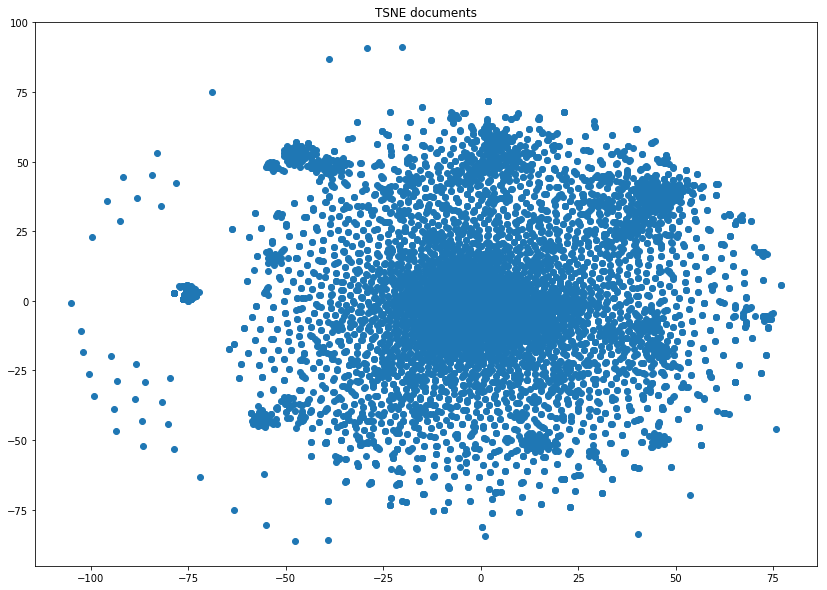

In [63]:
plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('TSNE documents')

### Group similar documents

In [70]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

#### Visualize clustering

Text(0.5,1,'TSNE documents 12 clusters')

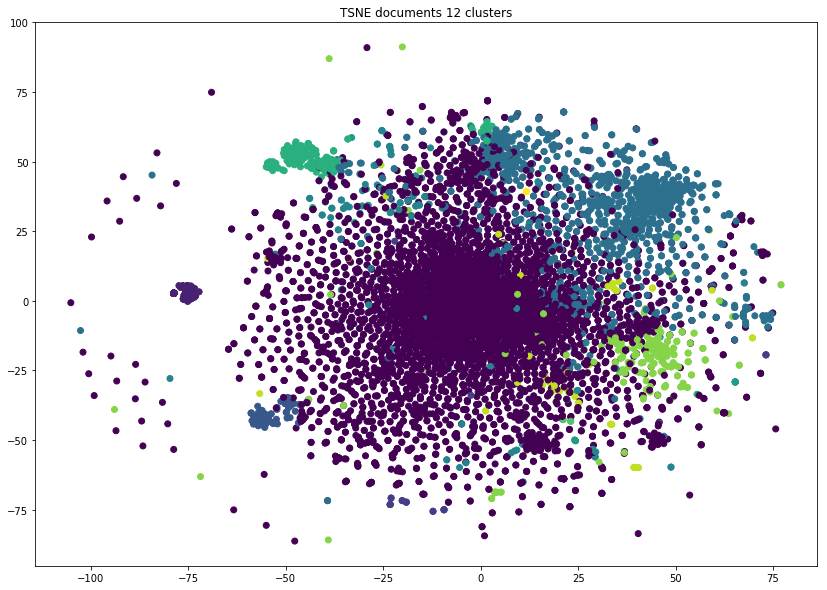

In [71]:
plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.title(f'TSNE documents {n_clusters} clusters')

### Save updated dataframe

In [73]:
mail_df['topic'] = kmeans.labels_
to_save_df = mail_df.drop(['lemmas', 'vec'], axis=1)
to_save_df.head()

date                      from                        to  \
0  1980-01-01 00:00:00   jeff.dasovich@enron.com     susan.scott@enron.com   
1  1980-01-01 00:00:00     susan.scott@enron.com     drew.fossum@enron.com   
2  1980-01-01 00:00:00        kim.ward@enron.com  jason.williams@enron.com   
3  1980-01-01 00:00:00  jason.williams@enron.com        kim.ward@enron.com   
4  1980-01-01 00:00:00  jason.williams@enron.com      tana.jones@enron.com   

                         subject  \
0           Re: Pedersen inquiry   
1     Gallup compressor contract   
2               Re: Border Steel   
3                           GTCs   
4  Re: Fletcher Challenge/Apache   

                                             message  \
0  Hey, you be talkin' to gas trash, counsel.\n\n...   
1  I've reviewed the O&M Agreement and here is a ...   
2  J.-\n\nJust got an RFP from Border Steel, Inc....   
3  Kim -\n\nAnnex A are the printed GTC\n\nAnnex ...   
4  Tana -\n\nWith respect to assignment of the Fl...   

                                 file  topic  
0       dasovich-j/all_documents/596.      0  
1      scott-s/discussion_threads/30.      0  
2      ward-k/discussion_threads/157.      0  
3  williams-j/discussion_threads/109.      0  
4        williams-j/all_documents/85.      0

In [74]:
to_save_df.to_csv('data/enron-mails-with-topic-meanvec.csv')